In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<h1>Building the Tables</h1>

<p>We've done the major preprocessing in other scripts, and now it's time to get our final tables together for fielders, catchers and pitchers with all appropriate stats.</p>

In [2]:
df_bat = pd.read_csv('../core/output/batting_pre.csv')
df_field = pd.read_csv('../core/output/fielding_pre.csv')
df_catch = pd.read_csv('../core/output/catching_pre.csv')
df_pitch = pd.read_csv('../core/output/pitching_pre.csv')
df_meta = pd.read_csv('../core/output/metadata.csv')

In [3]:
df_meta.head()

,retroID,POS,birthYear,bats,throws,weight,height,debutYear,finalYear
0,aardd001,P,1981.0,R,R,215.0,75.0,2004,2015
1,aaroh101,OF,1934.0,R,R,180.0,72.0,1954,1976
2,aarot101,1B,1939.0,R,R,190.0,75.0,1962,1971
3,aased001,P,1954.0,R,R,190.0,75.0,1977,1990
4,abada001,1B,1972.0,L,L,184.0,73.0,2001,2006


<h3>Making Metadata Usable</h3>

<p>We are interested in all of these fields, so we want to convert POS, bats and throws to numbers and use dummy variables. Note that we won't be using birthYear as-is, but rather subtracting it from current year to get a player's age for a season. This won't matter for the player career stats tensor so we can drop it here.</p>

In [4]:
df_meta.drop(columns=['birthYear'], inplace=True)

In [5]:
df_meta_pos = pd.get_dummies(df_meta['POS'], prefix='pos')
df_meta_bats = pd.get_dummies(df_meta['bats'], drop_first=True, prefix='bats')
df_meta_throws = pd.get_dummies(df_meta['throws'], prefix='throws')

In [6]:
dropped_meta_cols = ['POS', 'bats', 'throws']
df_meta.drop(columns=dropped_meta_cols, inplace=True)
df_meta.head()

,retroID,weight,height,debutYear,finalYear
0,aardd001,215.0,75.0,2004,2015
1,aaroh101,180.0,72.0,1954,1976
2,aarot101,190.0,75.0,1962,1971
3,aased001,190.0,75.0,1977,1990
4,abada001,184.0,73.0,2001,2006


In [7]:
df_meta = df_meta.join([df_meta_pos, df_meta_bats, df_meta_throws])
df_meta

,retroID,weight,height,debutYear,finalYear,pos_1B,pos_2B,pos_3B,pos_C,pos_OF,pos_P,pos_SS,bats_L,bats_R,throws_L,throws_R,throws_S
0,aardd001,215.0,75.0,2004,2015,0,0,0,0,0,1,0,0,1,0,1,0
1,aaroh101,180.0,72.0,1954,1976,0,0,0,0,1,0,0,0,1,0,1,0
2,aarot101,190.0,75.0,1962,1971,1,0,0,0,0,0,0,0,1,0,1,0
3,aased001,190.0,75.0,1977,1990,0,0,0,0,0,1,0,0,1,0,1,0
4,abada001,184.0,73.0,2001,2006,1,0,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15288,zupcb001,220.0,76.0,1991,1994,0,0,0,0,1,0,0,0,1,0,1,0
15289,zupof101,182.0,71.0,1957,1961,0,0,0,1,0,0,0,1,0,0,1,0
15290,zuveg101,195.0,76.0,1951,1959,0,0,0,0,0,1,0,0,1,0,1,0
15291,zuvep001,173.0,72.0,1982,1991,0,0,0,0,0,0,1,0,1,0,1,0


<p>We dropped first on the 'bats' column but for that and throws we can jutst leave one columns. We'll do 'bats/throws_L'.</p>

In [8]:
df_meta.drop(columns=['throws_S', 'throws_R', 'bats_R'], inplace=True)

<p>We want to use weight and height but we can normalize them</p>

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler()

In [11]:
df_meta[['weight', 'height']] = scaler.fit_transform(df_meta[['weight', 'height']])
df_meta

,retroID,weight,height,debutYear,finalYear,pos_1B,pos_2B,pos_3B,pos_C,pos_OF,pos_P,pos_SS,bats_L,throws_L
0,aardd001,0.569672,0.60,2004,2015,0,0,0,0,0,1,0,0,0
1,aaroh101,0.426230,0.45,1954,1976,0,0,0,0,1,0,0,0,0
2,aarot101,0.467213,0.60,1962,1971,1,0,0,0,0,0,0,0,0
3,aased001,0.467213,0.60,1977,1990,0,0,0,0,0,1,0,0,0
4,abada001,0.442623,0.50,2001,2006,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15288,zupcb001,0.590164,0.65,1991,1994,0,0,0,0,1,0,0,0,0
15289,zupof101,0.434426,0.40,1957,1961,0,0,0,1,0,0,0,1,0
15290,zuveg101,0.487705,0.65,1951,1959,0,0,0,0,0,1,0,0,0
15291,zuvep001,0.397541,0.45,1982,1991,0,0,0,0,0,0,1,0,0


<p>The metadata is now ready to go into the final tensor.</p>

<h2>Combining Batting Data</h2>

In [12]:
df_bat

,retroID,G,AB,PA,R,H,1B,2B,3B,HR,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,NL
0,aardd001,331,4,5,0,0,0,0,0,0,...,0,0.0,0,2,0,0,1,0,0,1
1,aaroh101,3298,12364,13940,2174,3771,2294,624,98,755,...,240,73.0,1402,1383,293,32,21,121,328,1
2,aarot101,437,944,1045,102,216,155,42,6,13,...,9,8.0,86,145,3,0,9,6,36,1
3,aased001,448,5,5,0,0,0,0,0,0,...,0,0.0,0,3,0,0,0,0,0,1
4,abada001,15,21,25,1,2,2,0,0,0,...,0,1.0,4,5,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15448,zupcb001,319,795,886,99,199,141,47,4,7,...,7,5.0,57,137,3,6,20,8,15,0
15449,zupof101,16,18,20,3,3,2,1,0,0,...,0,0.0,2,6,0,0,0,0,0,0
15450,zuveg101,266,142,167,5,21,18,2,1,0,...,0,1.0,9,39,0,0,16,0,3,1
15451,zuvep001,209,491,545,41,109,88,17,2,2,...,2,0.0,34,50,1,2,18,0,8,1


In [13]:
df = pd.merge(df_meta, df_bat, how='inner', on=['retroID'])

In [14]:
df.shape

(15293, 34)

In [15]:
df[df['retroID'] == 'rosep001']['pos_1B']

11865    0
Name: pos_1B, dtype: uint8

In [16]:
df.head(10)

,retroID,weight,height,debutYear,finalYear,pos_1B,pos_2B,pos_3B,pos_C,pos_OF,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,NL
0,aardd001,0.569672,0.60,2004,2015,0,0,0,0,0,...,0,0.0,0,2,0,0,1,0,0,1
1,aaroh101,0.426230,0.45,1954,1976,0,0,0,0,1,...,240,73.0,1402,1383,293,32,21,121,328,1
2,aarot101,0.467213,0.60,1962,1971,1,0,0,0,0,...,9,8.0,86,145,3,0,9,6,36,1
3,aased001,0.467213,0.60,1977,1990,0,0,0,0,0,...,0,0.0,0,3,0,0,0,0,0,1
4,abada001,0.442623,0.50,2001,2006,1,0,0,0,0,...,0,1.0,4,5,0,0,0,0,1,1
5,abadf001,0.590164,0.50,2010,2019,0,0,0,0,0,...,0,0.0,0,5,0,0,0,0,1,1
6,abbog001,0.508197,0.75,1973,1984,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
7,abboj001,0.508197,0.60,1989,1999,0,0,0,0,0,...,0,0.0,0,10,0,0,3,0,0,1
8,abboj002,0.467213,0.55,1997,2001,0,0,0,0,1,...,6,5.0,38,91,2,3,5,7,12,1
9,abbok001,0.508197,0.65,1991,1996,0,0,0,0,0,...,0,0.0,1,19,0,0,6,0,0,1


<p>We noticed that df_bat and df_meta don't have the same number of rows, so we want to find out what's going on there.</p>

In [17]:
df_bat[~df_bat['retroID'].isin(df_meta['retroID'])]

,retroID,G,AB,PA,R,H,1B,2B,3B,HR,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,NL
124,albeb101,6,18,18,1,5,4,1,0,0,...,0,0.0,0,2,0,0,0,0,0,0
370,aragj101,1,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,1
461,atkil101,1,1,1,1,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
629,banij001,1,1,1,0,1,1,0,0,0,...,0,0.0,0,0,0,0,0,0,0,1
651,barbr101,1,1,1,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14793,westj101,1,1,1,0,0,0,0,0,0,...,0,0.0,0,1,0,0,0,0,0,1
14981,willh101,10,9,10,0,2,2,0,0,0,...,0,0.0,1,4,0,0,0,0,0,1
15062,wilsi101,1,1,1,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
15262,wrigr002,1,3,3,0,0,0,0,0,0,...,0,0.0,0,1,0,0,0,0,1,0


In [18]:
df_bat[~df_bat['retroID'].isin(df_meta['retroID'])]['G'].max()

105

In [19]:
df_bat[~df_bat['retroID'].isin(df_meta['retroID'])]['G'].mean()

4.11875

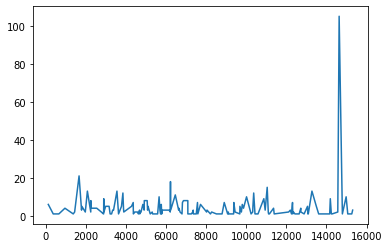

In [20]:
plt.plot(df_bat[~df_bat['retroID'].isin(df_meta['retroID'])]['G'])

<p>For the most part, we're talking about players who have played under 20 total games. We can easily drop these data points and not really affect the overall result.</p>

<h2>Combining the Tensors</h2>

<h3>Catchers</h3>

In [21]:
df_catch.shape[0] + df_field.shape[0] + df_pitch.shape[0]

24059

In [22]:
df_catch

,retroID,GS,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR
0,adamb105,1,27,6,0,0,0,0,0,1,0,0
1,adamb106,0,0,249,90,12,15,7,0,0,0,0
2,adamd101,3,78,9,2,0,0,1,0,0,0,0
3,adled101,65,1840,453,26,4,2,8,19,37,16,0
4,afent001,20,613,123,5,1,3,6,0,17,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1541,zimmd101,27,744,150,18,6,1,5,12,10,10,3
1542,zimmj101,298,8560,2131,150,21,26,19,84,110,80,4
1543,zinta001,0,3,2,0,0,0,0,0,0,0,0
1544,zunim001,613,16558,5120,301,27,29,43,0,275,115,0


In [23]:
np.intersect1d(df_catch.columns, df.columns)

array(['CS', 'SB', 'retroID'], dtype=object)

<p>The 'caught stealing' and 'stolen bases' stats appear both offensively and defensively (CS/SB against) for catchers. We need to keep them separate when merging the metadata and we can do so by just adding a prefix to the defensive stats.</p>

In [24]:
df_catch.rename(columns={'CS': 'CS_A', 'SB': 'SB_A'}, inplace=True)

In [25]:
catchers = pd.merge(df_catch, df, how='inner', on=['retroID'])

In [26]:
catchers

,retroID,GS,InnOuts,PO,A,E,DP,PB,WP,SB_A,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,NL
0,adamb105,1,27,6,0,0,0,0,0,1,...,0,0.0,0,5,0,0,0,0,0,0
1,adamb106,0,0,249,90,12,15,7,0,0,...,4,2.0,6,27,0,0,3,0,0,1
2,adamd101,3,78,9,2,0,0,1,0,0,...,0,0.0,1,3,0,0,0,0,1,0
3,adled101,65,1840,453,26,4,2,8,19,37,...,0,0.0,18,80,5,2,2,1,9,1
4,afent001,20,613,123,5,1,3,6,0,17,...,0,0.0,5,32,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1541,zimmd101,27,744,150,18,6,1,5,12,10,...,45,25.0,246,678,27,13,37,14,99,1
1542,zimmj101,298,8560,2131,150,21,26,19,84,110,...,1,2.0,78,154,12,11,31,4,38,1
1543,zinta001,0,3,2,0,0,0,0,0,0,...,0,0.0,5,34,0,0,0,1,0,1
1544,zunim001,613,16558,5120,301,27,29,43,0,275,...,2,4.0,158,812,1,48,8,11,42,0


In [27]:
catchers.columns

Index(['retroID', 'GS', 'InnOuts', 'PO', 'A', 'E', 'DP', 'PB', 'WP', 'SB_A',
       'CS_A', 'ZR', 'weight', 'height', 'debutYear', 'finalYear', 'pos_1B',
       'pos_2B', 'pos_3B', 'pos_C', 'pos_OF', 'pos_P', 'pos_SS', 'bats_L',
       'throws_L', 'G', 'AB', 'PA', 'R', 'H', '1B', '2B', '3B', 'HR', 'RBI',
       'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'NL'],
      dtype='object')

<p>There's no reason to waste columns on position for the catchers.</p>

In [28]:
catchers.drop(columns=['pos_1B', 'pos_2B', 'pos_3B', 'pos_C',
       'pos_OF', 'pos_P', 'pos_SS'], inplace=True)

In [29]:
catchers.columns

Index(['retroID', 'GS', 'InnOuts', 'PO', 'A', 'E', 'DP', 'PB', 'WP', 'SB_A',
       'CS_A', 'ZR', 'weight', 'height', 'debutYear', 'finalYear', 'bats_L',
       'throws_L', 'G', 'AB', 'PA', 'R', 'H', '1B', '2B', '3B', 'HR', 'RBI',
       'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'NL'],
      dtype='object')

<h3>Pitchers</h3>

In [30]:
np.intersect1d(df_pitch.columns, df.columns)

array(['BB', 'G', 'GIDP', 'H', 'HBP', 'HR', 'IBB', 'R', 'SF', 'SH', 'SO',
       'retroID'], dtype=object)

<p>We have quite a few common columns for pitching data and metadata. We'll do what we did for catching and just add 'A' to the end (for 'against'). Since there are quite a few, we'll define a conversion dictionary ahead of time. Before we do that, we see that we can drop the 'G' (games) column as it should be the same between the tables. We can also drop the position information.</p>

In [35]:
unwanted_pitching_columns = ['W', 'L', 'G', 'GS', 'SV']

In [36]:
pitchers = df_pitch.drop(columns=unwanted_pitching_columns)

In [42]:
pitchers.columns

Index(['retroID', 'BAOpp', 'ERA', 'CG', 'SHO', 'IPouts', 'H', 'ER', 'HR', 'BB',
       'SO', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP',
       'K%'],
      dtype='object')

<p>For reasons discussed in the report and based on previous research, we are particularly interested in strikeout rate as an 'advanced statistic'. We'll store it in the table for easy referencing later.</p>

In [39]:
pitchers['K%'] = pitchers['SO'] / pitchers['BFP']

In [41]:
pitchers

,retroID,BAOpp,ERA,CG,SHO,IPouts,H,ER,HR,BB,...,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,K%
0,aardd001,0.2574,5.1944,0,0,1011,296,160,41,183,...,12,16,1,1475,141,169,17,11,21,0.230508
1,aased001,0.2508,3.4931,22,5,3328,1085,468,89,457,...,22,7,3,4730,235,503,50,34,106,0.135518
2,abadf001,0.2447,4.0810,0,0,992,309,135,42,116,...,10,12,2,1399,97,143,7,12,25,0.200143
3,abbog001,0.2786,4.3317,37,5,3858,1405,627,162,352,...,18,32,5,5508,13,707,60,39,111,0.087872
4,abboj001,0.2804,4.4964,31,6,5022,1779,791,154,620,...,53,32,11,7211,5,880,70,47,200,0.123145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8020,zolds101,0.2700,3.6890,30,5,2788,956,366,54,301,...,8,3,4,3946,78,423,0,0,0,0.052458
8021,zubeb101,0.2717,5.3617,23,3,2358,767,374,35,468,...,28,4,1,3476,90,418,0,0,0,0.110184
8022,zumaj001,0.2286,3.4420,0,0,629,169,71,18,114,...,16,4,0,911,35,80,6,10,10,0.230516
8023,zuveg101,0.2760,4.1280,9,2,1927,660,253,56,203,...,10,27,1,2746,139,296,0,0,0,0.081209


<h3>Fielders</h3>

In [32]:
np.intersect1d(df_field.columns, df.columns)

array(['retroID'], dtype=object)

<p>We don't need to worry about common columns between the general fielding stats and metadata.</p>

In [136]:
fielders = pd.merge(df_field, df, how='inner', on=['retroID'])

In [137]:
fielders = fielders[~fielders['retroID'].isin(pitchers['retroID'])]

In [138]:
fielders

,retroID,GS,InnOuts,PO,A,E,DP,weight,height,debutYear,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,NL
1,aaroh101,2977,78414,7436,429,144,218,0.426230,0.45,1954,...,240,73.0,1402,1383,293,32,21,121,328,1
2,aarot101,206,6472,1317,113,22,124,0.467213,0.60,1962,...,9,8.0,86,145,3,0,9,6,36,1
4,abada001,4,138,37,1,1,3,0.442623,0.50,2001,...,0,1.0,4,5,0,0,0,0,1,1
8,abboj002,140,3688,299,2,8,0,0.467213,0.55,1997,...,6,5.0,38,91,2,3,5,7,12,1
10,abbok002,504,13474,938,1262,79,275,0.426230,0.40,1993,...,22,11.0,133,571,11,17,21,12,37,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14218,zoske001,8,404,16,42,2,8,0.405738,0.45,1991,...,0,0.0,1,13,0,0,1,1,1,1
14220,zubej001,26,702,167,12,2,11,0.467213,0.50,1996,...,1,0.0,12,20,1,1,1,1,4,1
14221,zulej001,36,1019,296,15,5,20,0.631148,0.75,2000,...,0,2.0,10,51,1,6,0,1,5,1
14223,zupcb001,198,5842,483,22,12,5,0.590164,0.65,1991,...,7,5.0,57,137,3,6,20,8,15,0


In [140]:
catchers

,retroID,GS,InnOuts,PO,A,E,DP,PB,WP,SB_A,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,NL
0,adamb105,1,27,6,0,0,0,0,0,1,...,0,0.0,0,5,0,0,0,0,0,0
1,adamb106,0,0,249,90,12,15,7,0,0,...,4,2.0,6,27,0,0,3,0,0,1
2,adamd101,3,78,9,2,0,0,1,0,0,...,0,0.0,1,3,0,0,0,0,1,0
3,adled101,65,1840,453,26,4,2,8,19,37,...,0,0.0,18,80,5,2,2,1,9,1
4,afent001,20,613,123,5,1,3,6,0,17,...,0,0.0,5,32,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1524,zimmd101,27,744,150,18,6,1,5,12,10,...,45,25.0,246,678,27,13,37,14,99,1
1525,zimmj101,298,8560,2131,150,21,26,19,84,110,...,1,2.0,78,154,12,11,31,4,38,1
1526,zinta001,0,3,2,0,0,0,0,0,0,...,0,0.0,5,34,0,0,0,1,0,1
1527,zunim001,535,14489,4356,264,21,22,39,0,248,...,2,4.0,138,714,1,45,8,11,38,0


In [169]:
fielders[fielders['retroID'].isin(catchers['retroID'])]

,retroID,GS,InnOuts,PO,A,E,DP,weight,height,debutYear,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,NL
54,adamb105,2,54,20,1,0,1,0.508197,0.55,1977,...,0,0.0,0,5,0,0,0,0,0,0
55,adamb106,0,0,0,0,0,0,0.446721,0.50,1910,...,4,2.0,6,27,0,0,3,0,0,1
108,ainse101,0,0,11,0,0,0,0.426230,0.40,1910,...,20,11.5,125,122,0,3,44,0,0,1
144,alexg101,22,500,83,6,3,4,0.487705,0.55,1975,...,8,12.0,154,381,12,5,4,19,34,1
151,alfaj002,1,31,8,2,0,1,0.610656,0.55,2016,...,3,0.0,22,179,8,18,0,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14111,yorkr101,0,0,11425,1030,136,1077,0.545082,0.50,1934,...,38,26.0,792,867,0,12,25,0,155,0
14139,younj001,843,23486,1679,756,115,113,0.426230,0.45,1976,...,60,55.0,332,589,30,36,18,33,80,1
14183,zaung001,0,33,3,2,0,1,0.385246,0.35,1995,...,23,19.0,479,544,30,29,14,31,87,1
14199,zimmd101,813,21993,1491,2204,150,417,0.364754,0.30,1954,...,45,25.0,246,678,27,13,37,14,99,1


<p>We have some catchers that are also in the fielders table.</p>

In [168]:
fielders[(fielders['retroID'].isin(catchers['retroID']) & fielders['pos_C'] == 1)]

,retroID,GS,InnOuts,PO,A,E,DP,weight,height,debutYear,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,NL
108,ainse101,0,0,11,0,0,0,0.426230,0.40,1910,...,20,11.5,125,122,0,3,44,0,0,1
144,alexg101,22,500,83,6,3,4,0.487705,0.55,1975,...,8,12.0,154,381,12,5,4,19,34,1
151,alfaj002,1,31,8,2,0,1,0.610656,0.55,2016,...,3,0.0,22,179,8,18,0,1,4,1
156,allaa001,0,33,15,0,0,2,0.590164,0.70,1986,...,23,18.0,87,223,4,9,35,16,27,1
169,alleg001,1,54,4,4,0,2,0.446721,0.40,1979,...,3,7.0,130,192,3,5,15,11,35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13914,wingi101,0,0,7,2,1,0,0.344262,0.35,1911,...,17,16.0,121,84,0,4,36,0,0,1
13956,wockj001,249,6120,1429,90,17,133,0.467213,0.45,1974,...,5,11.0,277,278,14,7,5,12,52,1
14066,wronr001,0,6,2,0,0,0,0.446721,0.50,1988,...,1,0.0,5,41,2,1,2,2,3,1
14074,wyneb001,0,6,0,0,0,0,0.467213,0.50,1976,...,10,13.0,626,428,41,17,58,36,119,0


In [170]:
to_inspect = fielders[(fielders['retroID'].isin(catchers['retroID']) & fielders['pos_C'] == 1)]['retroID']

In [171]:
catchers[catchers['retroID'].isin(to_inspect)]

,retroID,GS,InnOuts,PO,A,E,DP,PB,WP,SB_A,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,NL
6,ainse101,0,0,1528,361,72,31,34,0,0,...,20,11.5,125,122,0,3,44,0,0,1
7,alexg101,205,5481,1008,100,35,8,24,0,212,...,8,12.0,154,381,12,5,4,19,34,1
8,alfaj002,130,3430,1135,71,13,9,14,0,72,...,3,0.0,22,179,8,18,0,1,4,1
10,allaa001,453,11965,2395,208,52,24,41,0,292,...,23,18.0,87,223,4,9,35,16,27,1
11,alleg001,342,8959,1762,146,32,24,27,0,233,...,3,7.0,130,192,3,5,15,11,35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498,wingi101,0,0,1716,536,79,53,36,0,0,...,17,16.0,121,84,0,4,36,0,0,1
1502,wockj001,216,5957,1212,119,39,17,27,0,188,...,5,11.0,277,278,14,7,5,12,52,1
1508,wronr001,47,1360,296,32,8,3,4,0,25,...,1,0.0,5,41,2,1,2,2,3,1
1509,wyneb001,1164,31563,6281,583,75,88,61,0,708,...,10,13.0,626,428,41,17,58,36,119,0


<p>It looks like the information in the catchers table is a better indicator of the player's career.</p>

In [175]:
fielders[fielders['retroID'] == 'alexg101'][['debutYear', 'finalYear']]

,debutYear,finalYear
144,1975,1981


In [174]:
catchers[catchers['retroID'] == 'alexg101'][['debutYear', 'finalYear']]

,debutYear,finalYear
7,1975,1981


<p>Thee years line up. So for any catcher who appears in the fielders table with his position as catcher, we're going to drop him from the fielders table and only use the catchers information. We'll keep catchers in the fielders table if they're in a different position.</p>

In [176]:
fielders[fielders['pos_C'] == 1]

,retroID,GS,InnOuts,PO,A,E,DP,weight,height,debutYear,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,NL
108,ainse101,0,0,11,0,0,0,0.426230,0.40,1910,...,20,11.5,125,122,0,3,44,0,0,1
144,alexg101,22,500,83,6,3,4,0.487705,0.55,1975,...,8,12.0,154,381,12,5,4,19,34,1
151,alfaj002,1,31,8,2,0,1,0.610656,0.55,2016,...,3,0.0,22,179,8,18,0,1,4,1
156,allaa001,0,33,15,0,0,2,0.590164,0.70,1986,...,23,18.0,87,223,4,9,35,16,27,1
169,alleg001,1,54,4,4,0,2,0.446721,0.40,1979,...,3,7.0,130,192,3,5,15,11,35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13914,wingi101,0,0,7,2,1,0,0.344262,0.35,1911,...,17,16.0,121,84,0,4,36,0,0,1
13956,wockj001,249,6120,1429,90,17,133,0.467213,0.45,1974,...,5,11.0,277,278,14,7,5,12,52,1
14066,wronr001,0,6,2,0,0,0,0.446721,0.50,1988,...,1,0.0,5,41,2,1,2,2,3,1
14074,wyneb001,0,6,0,0,0,0,0.467213,0.50,1976,...,10,13.0,626,428,41,17,58,36,119,0


<p>All fielders with a position of 'C' are in the catchers table, so we don't have to worry about leaving any by filtering with the following predicate.</p>

In [184]:
fielders = fielders[~(fielders['retroID'].isin(catchers['retroID']) & fielders['pos_C'] == 1)]

In [185]:
fielders.shape

(5962, 40)